In [3]:
import cPickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from IPython import display
import scipy.sparse as sp
from scipy.stats import pearsonr
import os
os.chdir('/Users/zbutler/research/fire_prediction')
from geometry.get_xys import append_xy
from prediction.fire_clustering import cluster_fires
from geometry.grid_conversion import ak_bb
from plotting.plot_map import draw_map_nogrid_static
import geopandas as gpd
%matplotlib inline

In [4]:
# Load lightning
light = gpd.read_file('data/lightning/TOALightning2012Thru2015.shp')
print "loaded dataset with %d rows" % len(light)
light.iloc[0:10]

loaded dataset with 668157 rows


,AMPLITUDE,ERRELIPSEA,ERRSEMIMAJ,ERRSEMIMIN,GDOP,LATITUDE,LOCALDATET,LONGITUDE,MILLISECON,NETWORKCOD,OBJECTID,STRIKESEQN,STRIKETIME,STROKETYPE,UTCDATETIM,geometry
0,-7300.0,17,255,10,255,19.682515,2012-03-06,171.539495,581,0,144,0,None,GROUND_STROKE,2012-03-06,POINT (171.5394946 19.68251509999999)
1,-5200.0,-19,10,1,9,51.563973,2012-03-06,-155.090121,336,0,145,0,None,GROUND_STROKE,2012-03-06,POINT (-155.0901212 51.56397270000002)
2,-8700.0,1,27,2,26,39.750224,2012-03-06,-154.527965,701,0,146,0,None,GROUND_STROKE,2012-03-06,POINT (-154.5279649 39.750224)
3,-6500.0,16,255,10,255,18.832646,2012-03-06,172.442843,285,0,147,0,None,GROUND_STROKE,2012-03-06,POINT (172.4428428 18.83264630000002)
4,-7700.0,16,255,10,255,17.602377,2012-03-06,171.334500,360,0,148,0,None,GROUND_STROKE,2012-03-06,POINT (171.3345002 17.60237699999999)
5,-6400.0,17,255,10,255,18.641111,2012-03-06,170.653029,361,0,149,0,None,GROUND_STROKE,2012-03-07,POINT (170.6530294 18.6411114)
6,-9400.0,3,88,5,85,26.395146,2012-03-06,-153.051893,583,0,150,0,None,GROUND_STROKE,2012-03-07,POINT (-153.051893 26.39514580000002)
7,-35100.0,1,67,4,64,24.831824,2012-03-06,-153.172193,428,0,151,0,None,GROUND_STROKE,2012-03-07,POINT (-153.1721932 24.83182429999999)
8,-5400.0,19,255,9,255,23.825099,2012-03-06,168.356412,505,0,152,0,None,GROUND_STROKE,2012-03-07,POINT (168.3564123 23.8250989)
9,-6300.0,17,255,9,255,20.266606,2012-03-06,171.969021,262,0,153,0,None,GROUND_STROKE,2012-03-07,POINT (171.9690212 20.26660579999998)


In [5]:
# See how many fires are in ak_bb
in_bb = []
for row in light.index:
    lat = light.loc[row].LATITUDE
    lon = light.loc[row].LONGITUDE
    if (ak_bb[0] < lat < ak_bb[1]) and (ak_bb[2] < lon < ak_bb[3]):
        in_bb.append(row)
print "%d in Alaska" % len(in_bb)

426024 in Alaska


In [10]:
ak_light = light.loc[in_bb]
print "created %d len db" % len(ak_light)
ak_light.STRIKETIME.unique()

created 426024 len db


array([None, u'2012/03/08 08:14', u'2012/03/08 02:15', ...,
       u'2015/09/24 23:24', u'2015/09/25 05:16', u'2015/09/25 07:04'], dtype=object)

In [17]:
# Create a nice pandas database with the date split up into separate fields
pd_dict = dict()
pd_dict['lat'] = []
pd_dict['lon'] = []
pd_dict['day'] = []
pd_dict['month'] = []
pd_dict['year'] = []
pd_dict['amplitude'] = []
pd_dict['millisec'] = []
pd_dict['stroketype'] = []
for row in ak_light.index:
    pd_dict['lat'].append(ak_light.loc[row].LATITUDE)
    pd_dict['lon'].append(ak_light.loc[row].LONGITUDE)
    year,month,day = map(int, ak_light.loc[row].LOCALDATET.split('-'))
    pd_dict['day'].append(day)
    pd_dict['month'].append(month)
    pd_dict['year'].append(year)
    pd_dict['amplitude'].append(ak_light.loc[row].AMPLITUDE)
    pd_dict['millisec'].append(ak_light.loc[row].MILLISECON)
    pd_dict['stroketype'].append(ak_light.loc[row].STROKETYPE)
ak_l = pd.DataFrame(pd_dict)
ak_l.iloc[0:10]

,amplitude,day,lat,lon,millisec,month,stroketype,year
0,-900.0,6,59.734187,-159.665223,965,3,GROUND_STROKE,2012
1,-800.0,7,57.151463,-160.337396,213,3,GROUND_STROKE,2012
2,-1000.0,8,56.797220,-164.046543,735,3,GROUND_STROKE,2012
3,-5100.0,8,60.136043,-155.737774,635,3,GROUND_STROKE,2012
4,-400.0,8,62.559145,-148.119411,818,3,GROUND_STROKE,2012
5,-4700.0,10,55.303014,-153.730459,46,3,GROUND_STROKE,2012
6,-900.0,10,60.749635,-164.928437,762,3,GROUND_STROKE,2012
7,-1200.0,11,55.822369,-162.586637,458,3,GROUND_STROKE,2012
8,-1500.0,11,56.415247,-162.217703,203,3,GROUND_STROKE,2012
9,-2500.0,12,55.291613,-161.638156,469,3,GROUND_STROKE,2012


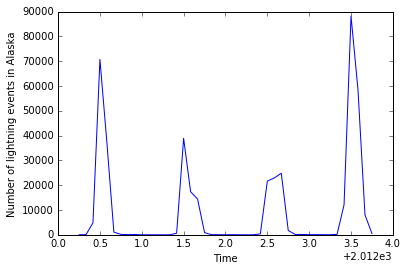

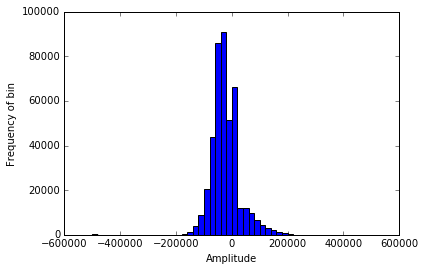

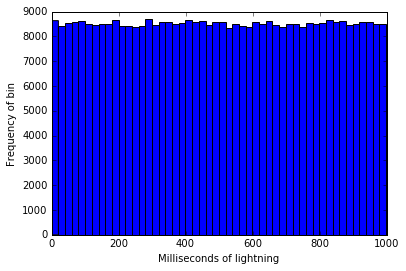

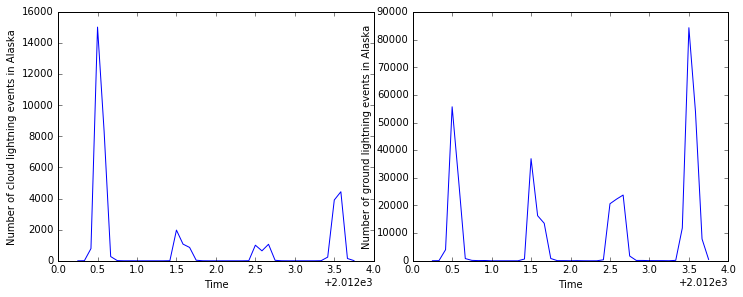

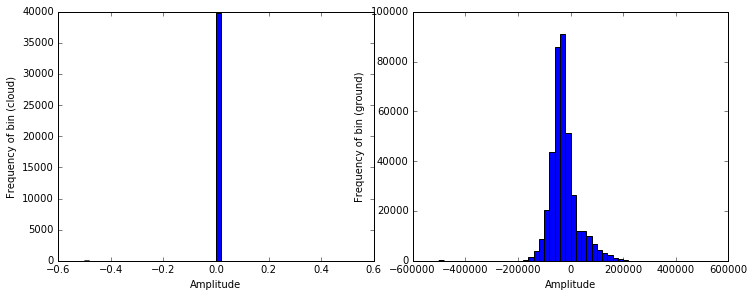

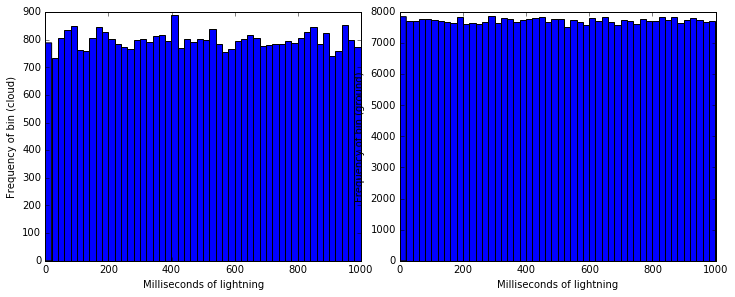

In [40]:
# Summary graphs for lightning, also save them to disk for drive purposes!
cloud_l = ak_l[ak_l.stroketype==u'CLOUD_STROKE']
ground_l = ak_l[ak_l.stroketype==u'GROUND_STROKE']
month = 3
year = 2012
n_light_arr = []
n_light_cloud = []
n_light_ground = []
yearmonth_arr = []
while year < 2015 or month < 10:
    n_light = len(ak_l[(ak_l.year == year) & (ak_l.month == month)])
    n_light_arr.append(n_light)
    n_light_cloud.append(len(cloud_l[(cloud_l.year == year) & (cloud_l.month == month)]))
    n_light_ground.append(len(ground_l[(ground_l.year == year) & (ground_l.month == month)]))
    yearmonth_arr.append(year + (month/12.))
    month += 1
    if month > 12:
        month = 1
        year += 1

plt.plot(yearmonth_arr, n_light_arr)
plt.xlabel('Time')
plt.ylabel('Number of lightning events in Alaska')
plt.savefig('pics/lightning_per_month.png')
plt.show()
plt.close()

plt.hist(ak_l.amplitude, bins=50)
plt.xlabel('Amplitude')
plt.ylabel('Frequency of bin')
plt.savefig('pics/lightning_amplitude_hist.png')
plt.show()
plt.close()

plt.hist(ak_l.millisec, bins=50)
plt.xlabel('Milliseconds of lightning')
plt.ylabel('Frequency of bin')
plt.savefig('pics/lightning_millisec_hist.png')
plt.show()
plt.close()

# Do all these plots by stroke type
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
f.tight_layout()
ax1.plot(yearmonth_arr, n_light_cloud)
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of cloud lightning events in Alaska')
ax2.plot(yearmonth_arr, n_light_ground)
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of ground lightning events in Alaska')
plt.savefig('pics/lightning_per_month_by_type.png')
plt.show()
plt.close()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
f.tight_layout()
ax1.hist(cloud_l.amplitude, bins=50)
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Frequency of bin (cloud)')
ax2.hist(ground_l.amplitude, bins=50)
ax2.set_xlabel('Amplitude')
ax2.set_ylabel('Frequency of bin (ground)')
plt.savefig('pics/lightning_amplitude_hist_by_type.png')
plt.show()
plt.close()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
f.tight_layout()
ax1.hist(cloud_l.millisec, bins=50)
ax1.set_xlabel('Milliseconds of lightning')
ax1.set_ylabel('Frequency of bin (cloud)')
ax2.hist(ground_l.millisec, bins=50)
ax2.set_xlabel('Milliseconds of lightning')
ax2.set_ylabel('Frequency of bin (ground)')
plt.savefig('pics/lightning_millisec_hist_by_type.png')
plt.show()
plt.close()

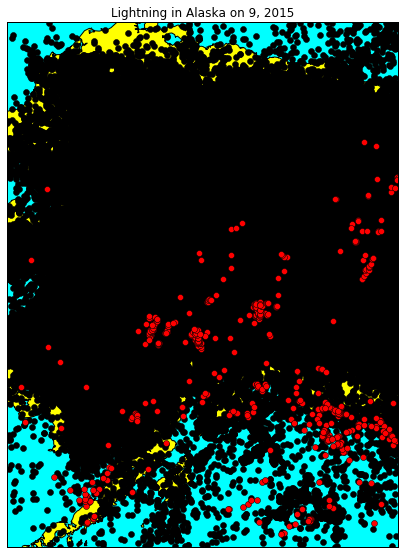

In [42]:
print ak_l.stroketype.unique()
plt.figure(figsize=(7,14))
mp = Basemap(projection="merc",
              lat_0=ak_bb[0], lon_0=ak_bb[2],
              llcrnrlat=ak_bb[0],
              llcrnrlon=ak_bb[2],
              urcrnrlat=ak_bb[1],
              urcrnrlon=ak_bb[3],
              resolution='i')

year = 2012
month = 3
prev_lats = []
prev_longs = []
while year < 2015 or month < 10:
    month_light = ak_l[(ak_l.month == month) & (ak_l.year == year)]
    display.clear_output(wait=True)
    plt.figure(figsize=(7,14))
    mp.drawmapboundary(fill_color='aqua')
    mp.fillcontinents(color='yellow',lake_color='aqua')
    mp.drawcoastlines()
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(month_light):
        today_longs, today_lats = mp(np.array(month_light.lon), np.array(month_light.lat))
        mp.plot(today_longs, today_lats, 'ro')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    plt.title("Lightning in Alaska on %d, %d" %(month, year))
    plt.show()
    time.sleep(.8)
    month += 1
    if month > 12:
        month = 1
        year += 1

In [44]:
with open('data/ak_fires.pkl') as fpkl:
    ak_fires = cPickle.load(fpkl)

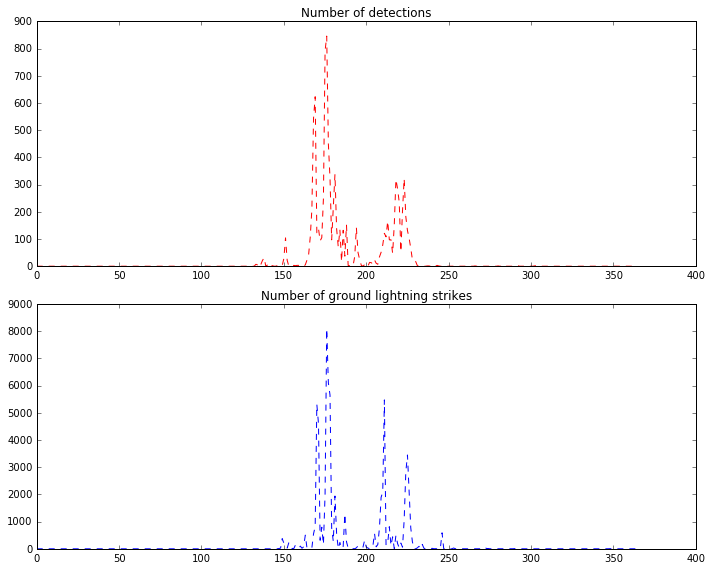

In [64]:
from util.daymonth import increment_day
day = 1
month = 1
year = 2013

light = []
fire = []
while year == 2013:
    light.append(len(ground_l[(ground_l.day==day) & (ground_l.month==month) & (ground_l.year==year)]))
    fire.append(len(ak_fires[(ak_fires.day==day) & (ak_fires.month==month) & (ak_fires.year==year)]))
    year, month, day = increment_day(year, month, day)
    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax1 = plt.subplot(211)
plt.plot(fire, 'r--')
plt.title('Number of detections')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(light, 'b--')
plt.title('Number of ground lightning strikes')
fig.tight_layout()
plt.show()

In [65]:
# Save ground_l
with open("data/lightning/ground_lightning.pkl", 'w') as fpkl:
    cPickle.dump(ground_l, fpkl)